In [1]:
import os

data_dir = "/kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200"

# Walk through directory and count files
total_files = 0
class_count = 0

for root, dirs, files in os.walk(data_dir):
    if files:
        total_files += len(files)
        class_count += 1
        # Print first file found as a sanity check
        if total_files == len(files): 
            print(f"Sample file found: {os.path.join(root, files[0])}")

print(f"---")
print(f"Found {total_files} images across {class_count} class folders.")

Sample file found: /kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200/l_01_p_0/l_01_p_0_sample_00567.png
---
Found 24000 images across 40 class folders.


In [2]:
# FINAL CORRECTED CODE FOR 40-FOLDER DATASET (10 OAM x 4 Radial)
# Fixes the label mismatch issues

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# ==================== 1. REGULARIZED MODEL (10 L, 4 P) ====================
class JointCNNOAM_MultiTask_Reg(nn.Module):
    def __init__(self, num_l: int = 10, num_p: int = 4): # <--- FIXED: 10 L, 4 P
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 0, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, 3, 1, 0, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 0, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        self.block4 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 0, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2))
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=0.1) 

        # Hardcoded input 2304 requires 96x96 images
        self.shared_fc1 = nn.Linear(2304, 2304)
        self.shared_fc2 = nn.Linear(2304, 244)
        self.head_l = nn.Linear(244, num_l)
        self.head_p = nn.Linear(244, num_p)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.flatten(x)
        
        x = torch.relu(self.shared_fc1(x))
        x = self.dropout(x)
        
        x = torch.relu(self.shared_fc2(x))
        x = self.dropout(x)
        
        return self.head_l(x), self.head_p(x)



Running on device: cuda


In [3]:
# ==================== 2. DATA LOADING ====================
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor()
])

# UPDATE PATH HERE
full_dataset = datasets.ImageFolder("/kaggle/input/oam-radial-dataset/content/VortexData_150class_5AT_mixed200", transform=transform)

# --- CRITICAL FIX HERE ---
def get_l_p_labels(class_idx_tensor):
    # Since you have 4 p-modes per l-mode (p=0,1,2,3), we divide by 4.
    return class_idx_tensor // 4, class_idx_tensor % 4

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)



In [4]:
# ==================== 3. SETUP & HYPERPARAMETERS ====================
model = JointCNNOAM_MultiTask_Reg(num_l=10, num_p=4).to(device) # <--- FIXED

criterion_l = nn.CrossEntropyLoss()
criterion_p = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

best_val_loss = float('inf')
patience = 15
patience_counter = 0
best_model_path = "/kaggle/working/best_oam_model.pth"

# Metrics Storage
train_losses, val_losses = [], []       
train_losses_l, val_losses_l = [], []   
train_losses_p, val_losses_p = [], []   

train_acc_joint, val_acc_joint = [], []
train_acc_l, val_acc_l = [], []
train_acc_p, val_acc_p = [], []

print(f"Dataset: {len(full_dataset):,} images. Starting Training (10 OAM x 4 Radial)...")



Dataset: 24,000 images. Starting Training (10 OAM x 4 Radial)...


In [5]:
# ==================== 4. TRAINING LOOP ====================
epochs_run = 0
for epoch in range(1, 201):
    epochs_run = epoch
    
    # --- TRAINING ---
    model.train()
    epoch_loss_total = epoch_loss_l = epoch_loss_p = 0.0
    correct_l = correct_p = correct_joint = total = 0

    for inputs, class_idx in train_loader:
        inputs, class_idx = inputs.to(device), class_idx.to(device)
        l_labels, p_labels = get_l_p_labels(class_idx)

        optimizer.zero_grad()
        l_logits, p_logits = model(inputs)

        loss_l = criterion_l(l_logits, l_labels)
        loss_p = criterion_p(p_logits, p_labels)
        loss = loss_l + loss_p

        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        epoch_loss_total += loss.item() * batch_size
        epoch_loss_l += loss_l.item() * batch_size
        epoch_loss_p += loss_p.item() * batch_size
        
        pred_l = l_logits.argmax(dim=1)
        pred_p = p_logits.argmax(dim=1)
        correct_l += pred_l.eq(l_labels).sum().item()
        correct_p += pred_p.eq(p_labels).sum().item()
        correct_joint += (pred_l.eq(l_labels) & pred_p.eq(p_labels)).sum().item()
        total += batch_size

    train_losses.append(epoch_loss_total / total)
    train_losses_l.append(epoch_loss_l / total)
    train_losses_p.append(epoch_loss_p / total)
    
    train_acc_joint.append(100. * correct_joint / total)
    train_acc_l.append(100. * correct_l / total)
    train_acc_p.append(100. * correct_p / total)

    # --- VALIDATION ---
    model.eval()
    epoch_val_loss_total = epoch_val_loss_l = epoch_val_loss_p = 0.0
    correct_l = correct_p = correct_joint = total = 0
    
    with torch.no_grad():
        for inputs, class_idx in val_loader:
            inputs, class_idx = inputs.to(device), class_idx.to(device)
            l_labels, p_labels = get_l_p_labels(class_idx)

            l_logits, p_logits = model(inputs)
            
            loss_l = criterion_l(l_logits, l_labels)
            loss_p = criterion_p(p_logits, p_labels)
            loss = loss_l + loss_p
            
            batch_size = inputs.size(0)
            epoch_val_loss_total += loss.item() * batch_size
            epoch_val_loss_l += loss_l.item() * batch_size
            epoch_val_loss_p += loss_p.item() * batch_size

            pred_l = l_logits.argmax(dim=1)
            pred_p = p_logits.argmax(dim=1)
            correct_l += pred_l.eq(l_labels).sum().item()
            correct_p += pred_p.eq(p_labels).sum().item()
            correct_joint += (pred_l.eq(l_labels) & pred_p.eq(p_labels)).sum().item()
            total += batch_size

    val_losses.append(epoch_val_loss_total / total)
    val_losses_l.append(epoch_val_loss_l / total)
    val_losses_p.append(epoch_val_loss_p / total)
    
    val_acc_joint.append(100. * correct_joint / total)
    val_acc_l.append(100. * correct_l / total)
    val_acc_p.append(100. * correct_p / total)

    scheduler.step()
    
    # --- EARLY STOPPING & PRINTING ---
    current_val_loss = val_losses[-1]
    save_msg = ""
    
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        save_msg = "[Saved Best]"
    else:
        patience_counter += 1
        save_msg = f"[No Imp. {patience_counter}/{patience}]"

    print(f"Epoch {epoch:3d} | "
          f"T-Loss: {train_losses[-1]:.3f} (L:{train_losses_l[-1]:.2f} P:{train_losses_p[-1]:.2f}) | "
          f"V-Loss: {val_losses[-1]:.3f} (L:{val_losses_l[-1]:.2f} P:{val_losses_p[-1]:.2f}) | "
          f"T-Acc: {train_acc_joint[-1]:.1f}% (L:{train_acc_l[-1]:.1f}% P:{train_acc_p[-1]:.1f}%) "
          f"V-Acc: {val_acc_joint[-1]:.1f}% (L:{val_acc_l[-1]:.1f}% P:{val_acc_p[-1]:.1f}%) {save_msg}")
        
    if patience_counter >= patience:
        print(f"\nEARLY STOPPING TRIGGERED at Epoch {epoch}. Model is not improving.")
        break



Epoch   1 | T-Loss: 1.286 (L:0.96 P:0.33) | V-Loss: 0.422 (L:0.34 P:0.08) | T-Acc: 59.5% (L:63.8% P:91.4%) V-Acc: 84.6% (L:86.8% P:97.8%) [Saved Best]
Epoch   2 | T-Loss: 0.557 (L:0.49 P:0.07) | V-Loss: 0.303 (L:0.27 P:0.03) | T-Acc: 80.1% (L:81.8% P:97.8%) V-Acc: 89.4% (L:90.0% P:99.2%) [Saved Best]
Epoch   3 | T-Loss: 0.455 (L:0.41 P:0.05) | V-Loss: 0.243 (L:0.24 P:0.00) | T-Acc: 83.8% (L:85.0% P:98.6%) V-Acc: 91.1% (L:91.2% P:100.0%) [Saved Best]
Epoch   4 | T-Loss: 0.390 (L:0.35 P:0.04) | V-Loss: 0.219 (L:0.22 P:0.00) | T-Acc: 86.3% (L:87.2% P:98.9%) V-Acc: 92.0% (L:92.0% P:100.0%) [Saved Best]
Epoch   5 | T-Loss: 0.380 (L:0.33 P:0.05) | V-Loss: 0.237 (L:0.23 P:0.01) | T-Acc: 86.9% (L:88.0% P:98.8%) V-Acc: 91.6% (L:91.9% P:99.7%) [No Imp. 1/15]
Epoch   6 | T-Loss: 0.348 (L:0.31 P:0.04) | V-Loss: 0.203 (L:0.20 P:0.00) | T-Acc: 87.7% (L:88.5% P:98.9%) V-Acc: 92.6% (L:92.6% P:99.9%) [Saved Best]
Epoch   7 | T-Loss: 0.339 (L:0.30 P:0.04) | V-Loss: 0.220 (L:0.22 P:0.00) | T-Acc: 88.4% (


Loading best model weights for final evaluation...
Saved /kaggle/working/metrics_plot.png


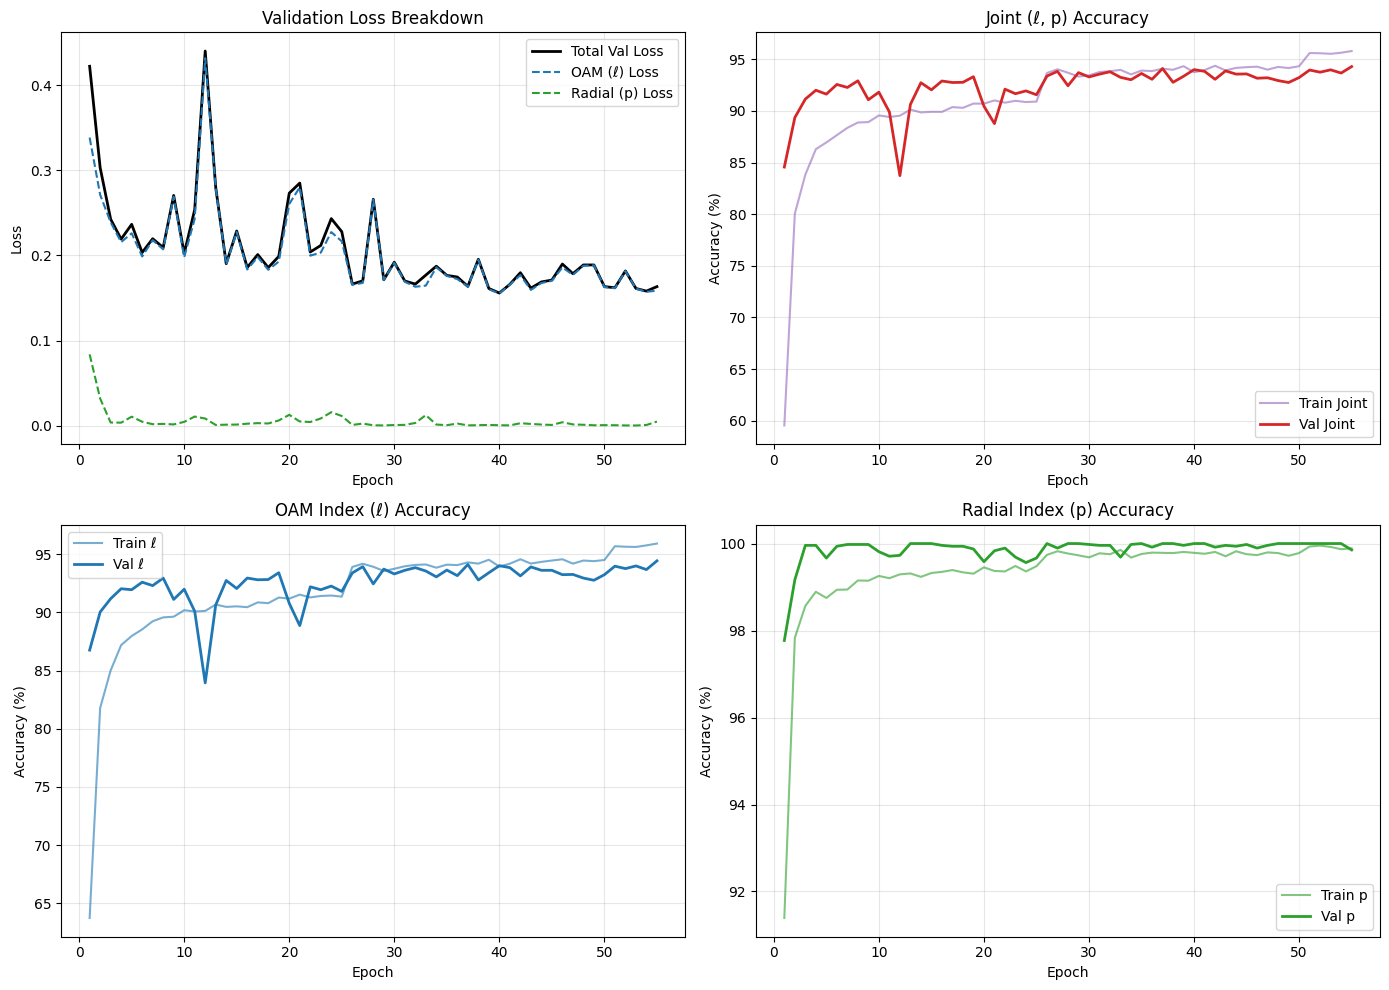

In [6]:
# ==================== 5. PLOTTING & SAVING ====================
print("\nLoading best model weights for final evaluation...")
model.load_state_dict(torch.load(best_model_path))
model.eval()

plt.figure(figsize=(14, 10))

# Plot 1: Validation Loss Breakdown
plt.subplot(2, 2, 1)
plt.plot(range(1, epochs_run + 1), val_losses,   label='Total Val Loss', color='black', linewidth=2)
plt.plot(range(1, epochs_run + 1), val_losses_l, label='OAM (ℓ) Loss',   color='tab:blue', linestyle='--')
plt.plot(range(1, epochs_run + 1), val_losses_p, label='Radial (p) Loss', color='tab:green', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Breakdown')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Joint Accuracy
plt.subplot(2, 2, 2)
plt.plot(range(1, epochs_run + 1), train_acc_joint, label='Train Joint', color='tab:purple', alpha=0.6)
plt.plot(range(1, epochs_run + 1), val_acc_joint,   label='Val Joint',   color='tab:red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Joint (ℓ, p) Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: OAM (l) Accuracy
plt.subplot(2, 2, 3)
plt.plot(range(1, epochs_run + 1), train_acc_l, label='Train ℓ', color='tab:blue', alpha=0.6)
plt.plot(range(1, epochs_run + 1), val_acc_l,   label='Val ℓ',   color='tab:blue', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('OAM Index (ℓ) Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Radial (p) Accuracy
plt.subplot(2, 2, 4)
plt.plot(range(1, epochs_run + 1), train_acc_p, label='Train p', color='tab:green', alpha=0.6)
plt.plot(range(1, epochs_run + 1), val_acc_p,   label='Val p',   color='tab:green', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Radial Index (p) Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/kaggle/working/metrics_plot.png')
print("Saved /kaggle/working/metrics_plot.png")
plt.show()



Generating Confusion Matrices...
Saved /kaggle/working/confusion_matrices.png


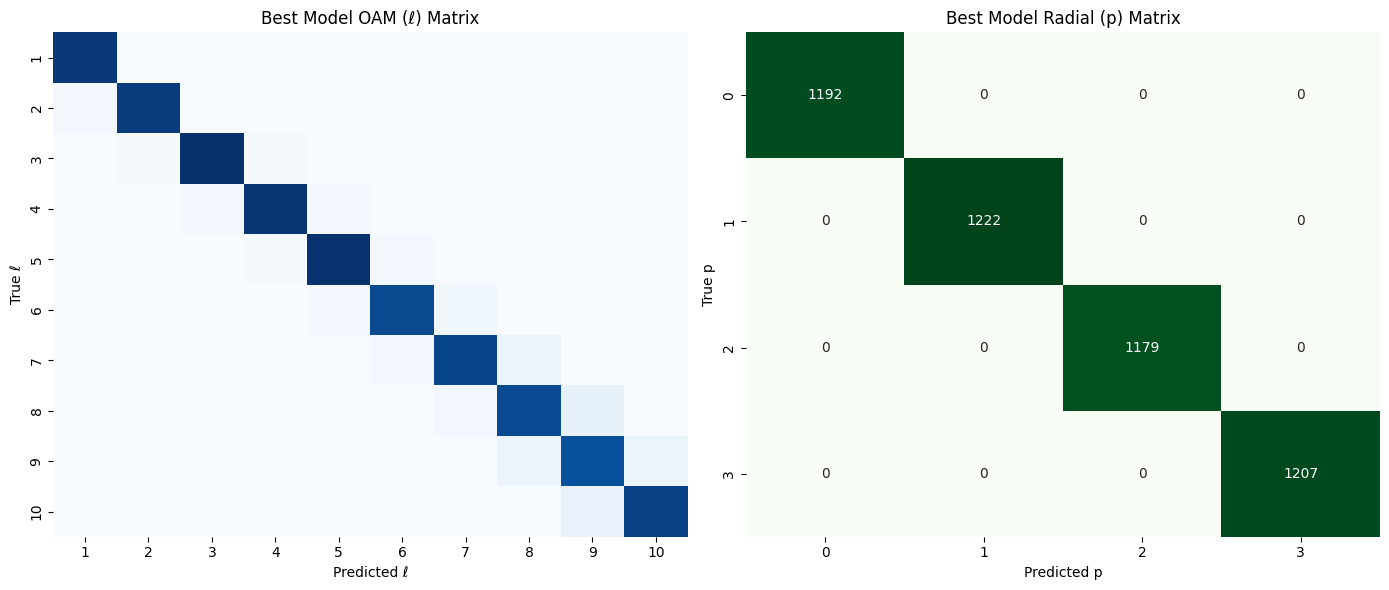

In [7]:
# ==================== 6. CONFUSION MATRICES & SAVING ====================
print("Generating Confusion Matrices...")
all_preds_l, all_labels_l = [], []
all_preds_p, all_labels_p = [], []

with torch.no_grad():
    for inputs, class_idx in val_loader:
        inputs = inputs.to(device)
        l_true, p_true = get_l_p_labels(class_idx.to(device))
        l_logits, p_logits = model(inputs)
        all_preds_l.extend(l_logits.argmax(dim=1).cpu().numpy())
        all_labels_l.extend(l_true.cpu().numpy())
        all_preds_p.extend(p_logits.argmax(dim=1).cpu().numpy())
        all_labels_p.extend(p_true.cpu().numpy())

plt.figure(figsize=(14, 6))

# --- FIXED CONFUSION MATRICES FOR 10 MODES ---
# OAM Matrix (0 to 9)
plt.subplot(1, 2, 1)
# Force 10x10 grid
cm_l = confusion_matrix(all_labels_l, all_preds_l, labels=range(10)) 
sns.heatmap(cm_l, annot=False, cmap='Blues', cbar=False, 
            xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.title(f'Best Model OAM (ℓ) Matrix')
plt.xlabel('Predicted ℓ')
plt.ylabel('True ℓ')

# Radial Matrix (0 to 3)
plt.subplot(1, 2, 2)
# Force 4x4 grid
cm_p = confusion_matrix(all_labels_p, all_preds_p, labels=range(4))
sns.heatmap(cm_p, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Best Model Radial (p) Matrix')
plt.xlabel('Predicted p')
plt.ylabel('True p')

plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrices.png')
print("Saved /kaggle/working/confusion_matrices.png")
plt.show()

In [8]:
import zipfile

# 8. ZIP ALL RESULTS FOR DOWNLOAD
print("\nZipping results for download...")
results_zip_path = "/kaggle/working/experiment_results.zip"

# Save raw metrics to .npz first
np.savez('/kaggle/working/training_metrics.npz', 
         train_losses=train_losses, val_losses=val_losses,
         train_losses_l=train_losses_l, val_losses_l=val_losses_l,
         train_losses_p=train_losses_p, val_losses_p=val_losses_p,
         train_acc_joint=train_acc_joint, val_acc_joint=val_acc_joint,
         train_acc_l=train_acc_l, val_acc_l=val_acc_l,
         train_acc_p=train_acc_p, val_acc_p=val_acc_p,all_preds_l=all_preds_l,
        all_labels_l=all_labels_l,all_preds_p=all_preds_p,all_labels_p=all_labels_p)

# Save raw confusion matrices to .npz
np.savez('/kaggle/working/confusion_matrices.npz', cm_l=cm_l, cm_p=cm_p)

with zipfile.ZipFile(results_zip_path, 'w') as zipf:
    # Add Model
    if os.path.exists(best_model_path):
        zipf.write(best_model_path, arcname='best_oam_model.pth')
    
    # Add Plots
    if os.path.exists('/kaggle/working/metrics_plot.png'):
        zipf.write('/kaggle/working/metrics_plot.png', arcname='metrics_plot.png')
    if os.path.exists('/kaggle/working/confusion_matrices.png'):
        zipf.write('/kaggle/working/confusion_matrices.png', arcname='confusion_matrices.png')
    
    # Add Data
    if os.path.exists('/kaggle/working/training_metrics.npz'):
        zipf.write('/kaggle/working/training_metrics.npz', arcname='training_metrics.npz')
    if os.path.exists('/kaggle/working/confusion_matrices.npz'):
        zipf.write('/kaggle/working/confusion_matrices.npz', arcname='confusion_matrices.npz')

print(f"Done! Download '{results_zip_path}' to save your work.")


Zipping results for download...
Done! Download '/kaggle/working/experiment_results.zip' to save your work.


Checking if data was saved properly 



In [14]:
import numpy as np

# 1. Load the file
# Replace 'training_history.npz' with your actual filename
data = np.load('/kaggle/working/training_metrics.npz')
data1=np.load('/kaggle/working/confusion_matrices.npz')

# 2. See what is inside (List the Keys)
# This tells you the names of the arrays you saved
print("Keys found:", data1.files)
print("Keys found:", data.files)



Keys found: ['cm_l', 'cm_p']
Keys found: ['train_losses', 'val_losses', 'train_losses_l', 'val_losses_l', 'train_losses_p', 'val_losses_p', 'train_acc_joint', 'val_acc_joint', 'train_acc_l', 'val_acc_l', 'train_acc_p', 'val_acc_p', 'all_preds_l', 'all_labels_l', 'all_preds_p', 'all_labels_p']


✅ Loaded '/kaggle/working/confusion_matrices.npz'
Keys found: ['cm_l', 'cm_p']
Loaded pre-calculated L-Matrix.
Loaded pre-calculated P-Matrix.


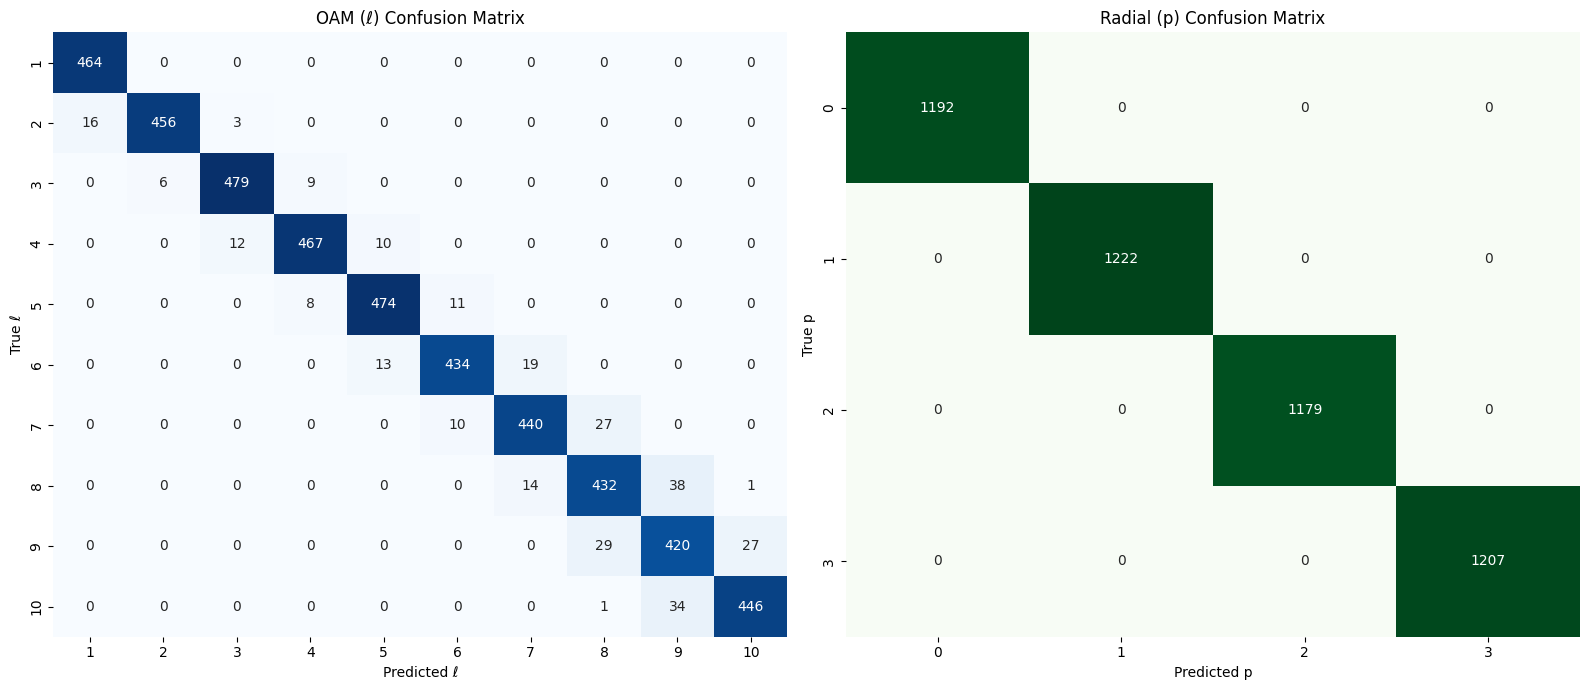

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix

# ================= CONFIGURATION =================
# Path to your saved .npz file
# Example: '/content/l_weighted_metrics.npz' or 'training_metrics.npz'
RESULTS_FILE = '/kaggle/working/confusion_matrices.npz' 

if not os.path.exists(RESULTS_FILE):
    print(f"❌ Error: File '{RESULTS_FILE}' not found. Please check the path.")
else:
    data = np.load(RESULTS_FILE)
    print(f"✅ Loaded '{RESULTS_FILE}'")
    print("Keys found:", data.files)

    plt.figure(figsize=(16, 7))

    # --- PLOT 1: OAM (L) MATRIX ---
    plt.subplot(1, 2, 1)
    
    # Case A: You saved the Raw Predictions (l_true, l_pred)
    if 'l_true' in data.files and 'l_pred' in data.files:
        cm_l = confusion_matrix(data['l_true'], data['l_pred'], labels=range(10))
        print("Generated L-Matrix from raw predictions.")
        
    # Case B: You saved the Matrix directly (cm_l)
    elif 'cm_l' in data.files:
        cm_l = data['cm_l']
        print("Loaded pre-calculated L-Matrix.")
        
    else:
        print("⚠️ Could not find L-Mode data (keys 'l_true' or 'cm_l' missing).")
        cm_l = None

    if cm_l is not None:
        sns.heatmap(cm_l, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=range(1, 11), yticklabels=range(1, 11))
        plt.title('OAM (ℓ) Confusion Matrix')
        plt.xlabel('Predicted ℓ')
        plt.ylabel('True ℓ')

    # --- PLOT 2: RADIAL (P) MATRIX ---
    plt.subplot(1, 2, 2)
    
    # Case A: Raw Predictions
    if 'p_true' in data.files and 'p_pred' in data.files:
        cm_p = confusion_matrix(data['p_true'], data['p_pred'], labels=range(4))
        print("Generated P-Matrix from raw predictions.")
        
    # Case B: Pre-calculated Matrix
    elif 'cm_p' in data.files:
        cm_p = data['cm_p']
        print("Loaded pre-calculated P-Matrix.")
        
    else:
        print("⚠️ Could not find P-Mode data (keys 'p_true' or 'cm_p' missing).")
        cm_p = None

    if cm_p is not None:
        sns.heatmap(cm_p, annot=True, fmt='d', cmap='Greens', cbar=False, 
                    xticklabels=range(0, 4), yticklabels=range(0, 4))
        plt.title('Radial (p) Confusion Matrix')
        plt.xlabel('Predicted p')
        plt.ylabel('True p')

    plt.tight_layout()
    plt.show()